# Feature and Structure Independence

to Do

Fix Features on Diagonal
Make running for GNN with separate Features
- fix plot colours to fix range

### Libs

In [11]:
## libs 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

## Basic
from tqdm import tqdm_notebook as tqdm
import argparse
import os
import random
import itertools
import time

# Computation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler

import scipy
from scipy.stats.stats import pearsonr 

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Network Processing
import networkx as nx
from networkx.generators import random_graphs

## node colour
orig_cmap = plt.cm.PuBu

### Supporting Function

In [12]:
## supporting functions
from support.preprocessing import sort_adjacency, reshape_A, calculate_A_shape, reconstruct_adjacency, pad_matrix, unpad_matrix, prepare_in_out
from support.metrics import compute_mig, compute_mi
from support.graph_generating import generate_single, generate_manifold, generate_topol_manifold, generate_topol_manifold
from support.latent_space import vis2D, visDistr
from support.comparing import compare_manifold_adjacency, compare_topol_manifold
from support.plotting import shiftedColorMap

## graph sampling
from sampling import ForestFire, Metropolis_Hastings, Random_Walk, Snowball, Ties, Base_Samplers

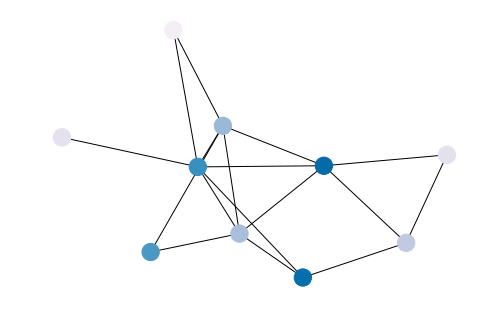

In [3]:
def get_graph(n,p,draw): 

    g = random_graphs.erdos_renyi_graph(n, p, seed=None, directed=False)

    if draw:
        f = np.random.rand(n)
        orig_cmap = plt.cm.PuBu
        fixed_cmap = shiftedColorMap(orig_cmap, start=min(f), midpoint=0.5, stop=max(f), name='fixed')
        nx.draw(g, node_color=f, font_color='white', cmap = fixed_cmap)
        plt.show()
    
    return g

g = get_graph(n = 10, p = 0.4, draw = True)

In [4]:
def feature_write(a, f, diag_offset):
    
    row, col = np.diag_indices(f.shape[0])

    if diag_offset > -2:  ## only write to adjacency of 2D_conv or MLP used
        a = a.astype(float)
        
        if f.shape[1] == 1:
            
            ## fill the diagonal with features
            a[row, col] = np.squeeze(f)
            
        else:
            
            a[row,col] = f
        
    return a


def feature_readoff(reconstructed_a, analyzeArgs):
    
    f = reconstructed_a.diagonal()
    if analyzeArgs["normalize_feature"]:
        f = (f - np.min(f))/np.ptp(f) ## normalize feature values
    return f


In [27]:
def generate_data(dataArgs): 
    
    
    ## Data ________________________________

    G = np.zeros((dataArgs["n_graphs"], *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
    F = np.zeros((dataArgs["n_graphs"], dataArgs["n_max"], dataArgs["n_features"]))
    print("feature_dependence:",dataArgs["feature_dependence"] )
    
    ## Ground Truth Labels ______________________________

    T = list()

    ## Generate Graph Data_______________________________

    for i in tqdm(range(0,dataArgs["n_graphs"])):
        
        ## Generate Graph Type ______________________________________________

        if dataArgs["fix_n"] == True:
            n = dataArgs["n_max"] # generate fixed number of nodes n_max
        else:
            n = random.randint(1, dataArgs["n_max"]) # generate number of nodes n between 1 and n_max and

        p = np.random.rand(1)  # float in range 0 - 1 
        g = get_graph(n, p, draw = False)
        
        
        ## Generate / Load Node Features ______________________________________________

        if dataArgs["feature_dependence"] == "random":
            f = np.random.rand(n, dataArgs["n_features"])                   ## float
            #F[i] = np.random.randint(2, size=(dataArgs["n_max"],dataArgs["n_features"]))   ## int
            
        if dataArgs["feature_dependence"] == "degree":
            if dataArgs["n_features"] == 1:
                
                f = np.asarray([int(x[1]) for x in g.degree()])   ## sort features by node degree
                f = (f+1) / max(f+1)
                f = np.reshape(f, (f.shape[-1],1))
                
        if dataArgs["feature_dependence"] == "p":  
            if dataArgs["n_features"] == 1:
                f = np.ones((n ,1)) * p
                
        ## padding feature vector with zeroes
        if dataArgs["n_max"] - f.shape[0] > 0:
            zeroes = np.zeros((dataArgs["n_max"] - f.shape[0], 1))
            f = np.concatenate((f, zeroes))
        
        #nx.draw(g, cmap=plt.get_cmap('PuBu'), node_color=np.squeeze(f), font_color='white')
        #plt.show()
        
        g, a = sort_adjacency(g)
        a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
        a = feature_write(a, f, dataArgs["diag_offset"])
        
        a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])
        

        ## Build Data Arrays___________________________________________________

        F[i] = f
        G[i] = a_transformed

        t = dict()
        t["n"] = n
        t["p"] = p
        
        T.append(t)



    ## Input and Output Size ___________________________________________________________

    T, input_shape, output_shape = prepare_in_out(T, dataArgs["diag_offset"], calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"]))
    print("input_shape:", input_shape, ", output_shape:", output_shape)
    
    ## scale features in F for smoother training
    #scaler = MinMaxScaler()
    #scaler.fit(F)
    #F = scaler.transform(F)
    
    return G,T,F,input_shape,output_shape
    
dataArgs = {"n_graphs": 10000, "n_max": 16, "fix_n": False, "diag_offset": -2, "diag_value": 1, "clip": False, "n_features": 1, "feature_dependence": "p"}  #"diag_offset" - 1 == full adjacency
G, T, F, input_shape, output_shape = generate_data(dataArgs)

feature_dependence: p



input_shape: (16, 16, 1) , output_shape: (16, 16, 1)


# beta-VAE Model

In [6]:
## Model Setup
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Dropout, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split
from support.keras_dgl.utils import *
from support.keras_dgl.layers import MultiGraphCNN


class VAE():

    # reparameterization trick
    # instead of sampling from Q(z|X), sample eps = N(0,I)
    # then z = z_mean + sqrt(var)*eps

    def sampling(self, args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.
        # Arguments
            args (tensor): mean and log of variance of Q(z|X)
        # Returns
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    
    def __init__(self, modelArgs, trainArgs, g_train, g_test, f_train, f_test):

        ## MODEL ______________________________________________________________

        ## Multi-layer Perceptron without convolutions__________________________________
        if modelArgs["nn_architecture"] == "mlp":
            ## 1) build encoder model __________________________

            inputs = Input(shape=modelArgs["input_shape"], name='encoder_input')
            x = Dense(128, activation='relu')(inputs)
            x = Dense(64, activation='relu')(x)
            z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(x)
            z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(x)

            # use reparameterization trick to push the sampling out as input
            # note that "output_shape" isn't necessary with the TensorFlow backend
            z = Lambda(self.sampling, output_shape=(modelArgs["latent_dim"],), name='z')([z_mean, z_log_var])

            ## 2) build decoder model __________________________

            latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
            y = Dense(64, activation='relu')(latent_inputs)
            y = Dense(128, activation='relu')(y)
            graph_outputs = Dense(modelArgs["output_shape"], activation='sigmoid')(y)

            
            
            
        ## Convolutional Neural Network_________________________________

        if modelArgs["nn_architecture"] == "2D_conv":

            ## 1) build encoder model____________________________________

            inputs = Input(shape=modelArgs["input_shape"], name='encoder_input')
            x = inputs

            for i in range(2):
                modelArgs['filters'] *= 2
                x = Conv2D(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'], activation='relu', strides=2, padding='same')(x)

            # shape info needed to build decoder model
            shape = K.int_shape(x)

            # generate latent vector Q(z|X)
            x = Flatten()(x)
            x = Dense(16, activation='relu')(x)
            z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(x)
            z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(x)

            # use reparameterization trick to push the sampling out as input
            # note that "output_shape" isn't necessary with the TensorFlow backend
            z = Lambda(self.sampling, output_shape=(modelArgs["output_shape"],), name='z')([z_mean, z_log_var])

            ## 2) build decoder model____________________________________

            latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
            x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
            x = Reshape((shape[1], shape[2], shape[3]))(x)

            for i in range(2):
                x = Conv2DTranspose(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'], activation='relu', strides=2, padding='same')(x)
                modelArgs['filters'] //= 2

            graph_outputs = Conv2DTranspose(filters=1, kernel_size=modelArgs['kernel_size'], activation='sigmoid',padding='same', name='decoder_output')(x)


            
            
            
            
        ## Graph Neural Network Architecture __________________________________

        if modelArgs["nn_architecture"] == "gnn":

            ## 1) build encoder model____________________________________

            # build graph_conv_filters
            SYM_NORM = True
            num_filters = 2
            print("g_train shape:", g_train.shape)
            graph_conv_filters = preprocess_adj_tensor_with_identity(np.squeeze(g_train), SYM_NORM)

            
            # build model
            X_input = Input(shape=(f_train.shape[1], f_train.shape[2]))
            graph_conv_filters_input = Input(shape=(graph_conv_filters.shape[1], graph_conv_filters.shape[2]))
            
            
            # define inputs of features and graph topologies
            inputs = [X_input, graph_conv_filters_input]

            x = MultiGraphCNN(100, num_filters, activation='elu')([X_input, graph_conv_filters_input])
            x = Dropout(0.2)(x)
            x = MultiGraphCNN(100, num_filters, activation='elu')([x, graph_conv_filters_input])
            x = Dropout(0.2)(x)
            x = Lambda(lambda x: K.mean(x, axis=1))(x)  # adding a node invariant layer to make sure output does not depends upon the node order in a graph.
            z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(x)
            z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(x)

            # use reparameterization trick to push the sampling out as input
            # note that "output_shape" isn't necessary with the TensorFlow backend
            z = Lambda(self.sampling, output_shape=(modelArgs["latent_dim"],), name='z')([z_mean, z_log_var])

            
            ## 2) build decoder model __________________________

            ## shape info needed to build decoder model
            inputs_2D_encoder = Input(shape=modelArgs["input_shape"], name='encoder_input')
            x_2D = inputs_2D_encoder
            for i in range(2):
                modelArgs['filters'] *= 2
                x_2D = Conv2D(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'], activation='relu',strides=2, padding='same')(x_2D)
            shape_2D = K.int_shape(x_2D)

            latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
            x_2D = Dense(shape_2D[1] * shape_2D[2] * shape_2D[3], activation='relu')(latent_inputs)
            x_2D = Reshape((shape_2D[1], shape_2D[2], shape_2D[3]))(x_2D)

            for i in range(2):
                x_2D = Conv2DTranspose(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'],activation='relu', strides=2, padding='same')(x_2D)
                modelArgs['filters'] //= 2

            graph_outputs = Conv2DTranspose(filters=1, kernel_size=modelArgs['kernel_size'], activation='sigmoid',padding='same', name='decoder_output')(x_2D)

    
    
        ## INSTANTIATE___________________________________

        ## 1) instantiate encoder model
        encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        encoder.summary()
        # plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

        ## 2) instantiate decoder model
        graph_decoder = Model(latent_inputs, graph_outputs, name='decoder')
        graph_decoder.summary()
        # plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

        ## 3) instantiate VAE model
        outputs = graph_decoder(encoder(inputs)[2])
        vae = Model(inputs, outputs, name='conv_vae')
        # vae.summary()

    
    

        ## LOSS FUNCTIONS ______________________________________
        
        def reconstr_loss_func(y_true, y_pred):

            ## RECONSTRUCTION LOSS_______________________

            if trainArgs["loss"] == "mse":

                if modelArgs["nn_architecture"] == "mlp":
                    reconstruction_loss = mse(y_true[0], y_pred[0])
                    reconstruction_loss *= modelArgs["input_shape"]

                elif modelArgs["nn_architecture"] == "2D_conv" or "gnn":
                    reconstruction_loss = mse(K.flatten(y_true[0]), K.flatten(y_pred[0]))
                    reconstruction_loss *= modelArgs["input_shape"][0] * modelArgs["input_shape"][1]

            if trainArgs["loss"] == "binary_crossentropy":

                if modelArgs["nn_architecture"] == "mlp":
                    reconstruction_loss = binary_crossentropy(y_true[0], y_pred[0])
                    reconstruction_loss *= modelArgs["input_shape"]

                elif modelArgs["nn_architecture"] == "2D_conv" or "gnn":
                    print(y_true[0], y_pred[0])
                    reconstruction_loss = binary_crossentropy(K.flatten(y_true[0]), K.flatten(y_pred[0]))
                    reconstruction_loss *= modelArgs["input_shape"][0] * modelArgs["input_shape"][1]

                    
            ## KL LOSS _____________________________________________

            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.5

            
            ## COMPLETE LOSS __________________________________________________

            reconstr_loss = K.mean(reconstruction_loss + (trainArgs["beta"] * kl_loss))

            return reconstr_loss


        
        
        ## MODEL COMPILE______________________________________________
        
        vae.compile(optimizer='adam', loss=reconstr_loss_func, metrics=['mae'])
        vae.summary()
        
        

        ## TRAIN______________________________________________

        # load the autoencoder weights

        if trainArgs["weights"] == "load":

            vae.load_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")

        # train the autoencoder

        elif trainArgs["weights"] == "train":

            # Set callback functions to early stop training and save the best model so far
            callbacks = [EarlyStopping(monitor='val_loss', patience=trainArgs["early_stop"]), ModelCheckpoint(filepath="models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5",save_best_only=True)]

            if modelArgs["nn_architecture"] == "gnn":

                # build graph_conv_filters
                SYM_NORM = True
                g_train_mod = preprocess_adj_tensor_with_identity(np.squeeze(g_train), SYM_NORM)
                g_test_mod = preprocess_adj_tensor_with_identity(np.squeeze(g_test), SYM_NORM)

                vae.fit([f_train, g_train_mod], [g_train], epochs=trainArgs["epochs"],batch_size=trainArgs["batch_size"], callbacks=callbacks,validation_data=([f_test, g_test_mod], [g_test]))
                vae.save_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")
                
                models = (encoder, graph_decoder)
                data = ([g_test_mod, g_test], f_test)

            elif modelArgs["nn_architecture"] == "2D_conv" or "mlp":

                vae.fit(g_train, [g_train], epochs=trainArgs["epochs"], batch_size=trainArgs["batch_size"], callbacks=callbacks, validation_data=(g_test, [g_test]))
                vae.save_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")
                
                models = (encoder, graph_decoder)
                data = (g_test, f_test)
           
        self.model = models
        self.data = data

In [7]:
modelArgs = {"nn_architecture": "gnn", "latent_dim": 2, "filters": 16, "kernel_size": 3, "input_shape": input_shape, "output_shape": output_shape, "param_loss": False,}
trainArgs = {"beta": 1, "loss": "mse", "weights": "train", "early_stop": 3, "batch_size": 12, "epochs": 50, "data_split": 0.2}


## Train and Validation Split _______________________________________________
g_train, g_test, f_train, f_test = train_test_split(G, F, test_size=trainArgs["data_split"],random_state=1, shuffle=True)


vae = VAE(modelArgs, trainArgs, g_train, g_test, f_train, f_test)

models = vae.model 
data = vae.data

g_train shape: (8000, 16, 16, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 16)       0                                            
__________________________________________________________________________________________________
multi_graph_cnn_1 (MultiGraphCN (None, 16, 100)      300         input_1[0][0]                    
                                                                 input_2[0][0]         

# Analysis

In [53]:
## unpad the adjacency matrix by looking at diagonal values

def unpad_matrix(max_adjacency, node_margin, diag_offset, fix_n):
    if fix_n == False:

        keep = list()
        for i in range(0, max_adjacency.shape[0]):
            if diag_offset > -2:
                if max_adjacency[i][i] > node_margin:
                    keep.append(i)
            if diag_offset == -2:
                if max_adjacency[i][i] > 1 - node_margin:
                    print(print(max_adjacency[i][i]))
                    keep.append(i)

        ## delete rows and columns
        max_adjacency = max_adjacency[:, keep]  # keep columns
        max_adjacency = max_adjacency[keep, :]  # keep rows

    return max_adjacency


In [61]:
def generate_single_features(analyzeArgs, modelArgs, dataArgs, models):
    
    encoder, graph_decoder = models  # trained models

    print("latent dimensions:", modelArgs["latent_dim"])

    z_sample = np.zeros(modelArgs["latent_dim"])
    z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))

    for i, dim in enumerate(analyzeArgs["z"]):
        z_sample[0][dim] = analyzeArgs["activations"][i]

    x_decoded = graph_decoder.predict(z_sample)

    ## reconstruct upper triangular adjacency matrix
    reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])
    
    ## read off the node features
    reconstructed_a = unpad_matrix(reconstructed_a, 2dataArgs["diag_offset"], dataArgs["fix_n"])
    f = feature_readoff(reconstructed_a, analyzeArgs)
    print("features:", f)

    print(reconstructed_a.shape)
    print(f.shape)
    
    ## reconstruct graph
    g = nx.from_numpy_matrix(reconstructed_a)
    fixed_cmap = shiftedColorMap(orig_cmap, start=min(f), midpoint=0.5, stop=max(f), name='fixed')
    nx.draw(g, node_color=f, font_color='white', cmap = fixed_cmap)
    plt.show()
    
    ax = sns.distplot(f, rug = True)
    ax.set_title('Node Feature Distribution', fontweight = "bold")
    ax.set(xlabel="feature value", ylabel="frequency")
    plt.show()
    

latent dimensions: 2
[0, 1, 2, 3, 4, 8, 9, 10, 11, 12, 13]
features: [0.9749843  0.89376986 0.         0.5003148  0.75444233 0.8844162
 0.9002197  0.28365305 0.78450745 1.         0.87436885]
(11, 11)
(11,)


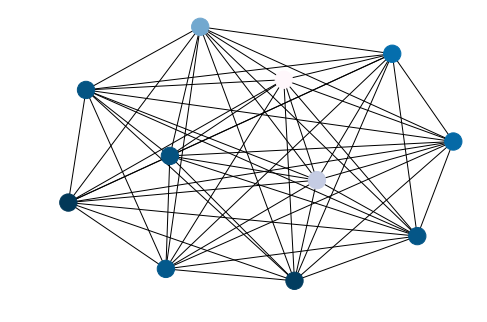

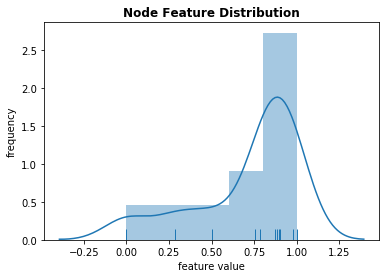

In [62]:
analyzeArgs = {"z": [0,1], "activations": [-10,+10], "normalize_feature": True}
generate_single_features(analyzeArgs, modelArgs, dataArgs, models)

## Change Structure or Features

In [ ]:
def latent_space_feature_correlation(analyzeArgs, modelArgs, models, data, batch_size=128,model_name="vae_graph"):

    
    ## unpack models and data__________________________
    
    encoder, graph_decoder = models  # trained models
    A, F = data
    if modelArgs["nn_architecture"] == "gnn":
        A_mod, A = A
                
    mod_degree = np.linspace(0,dataArgs["n_max"],analyzeArgs["n_config_graphs"], dtype = int)      
        
    ## topol parameters
    topol_params = ["density", "diameter", "cluster_coef", "assort", "#edges", "avg_degree"]

    ## store graphs and targets
    # shape: n_config_graphs, params, upper_A_size
    A_mod = np.zeros((analyzeArgs["n_config_graphs"], *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
    F_mod = np.zeros((analyzeArgs["n_config_graphs"], dataArgs["n_max"], dataArgs["n_features"]))
    

    for i, (a, f) in enumerate(zip(A[:analyzeArgs["n_config_graphs"]], F[:analyzeArgs["n_config_graphs"]])):

        ## Generate Graph Type ______________________________________________
            
        #f = feature_readoff(a, analyzeArgs) # read off the features
        a = reconstruct_adjacency(np.squeeze(a), dataArgs["clip"], dataArgs["diag_offset"])
        a = unpad_matrix(a, dataArgs["diag_value"], dataArgs["fix_n"])
        
        if analyzeArgs["f_variation"] == "random":

            for mod in range(0, mod_degree[i]):
                swap = np.random.randint(low = 0, high = f.shape[0], size = 2)
                temp = f[swap[0]]
                f[swap[0]] = f[swap[1]]
                f[swap[1]] = temp
                
                
        elif analyzeArgs["f_variation"] == "equal":
    
            norm_std = mod_degree[i] / max(mod_degree)
            norm_mean = np.mean(f) 
            
            for i in range(0,len(f)):
                
                if f[i] > norm_mean:
                    f[i] = f[i] - (norm_std * (np.abs(f[i] - norm_mean)))
                else:
                    f[i] = f[i] + (norm_std * (np.abs(f[i] - norm_mean )))
                    
                    
        elif analyzeArgs["f_variation"] == "uniform":
    
            f = np.ones(f.shape[0]) * (mod_degree[i] / max(mod_degree))
            f = np.reshape(f, (f.shape[-1],1))
                    
        F_mod[i] = f
    
        a_mod = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])
        a_mod = feature_write(a_mod, f, dataArgs["diag_offset"])  # write the modified feature to adjacency

        upper_a_mod = reshape_A(a_mod, dataArgs["diag_offset"])
        A_mod[i] = upper_a_mod

        
        

    ## ENCODER - 2D Digit Classes ______________________________________________
    
    if modelArgs["nn_architecture"] == "gnn":
        print("gnn")
        # build graph_conv_filters
        SYM_NORM = True
        g_train_mod = preprocess_adj_tensor_with_identity(np.squeeze(A_mod), SYM_NORM)
        z_mean, _, _ = encoder.predict([F_mod, g_train_mod], batch_size = batch_size)

    elif modelArgs["nn_architecture"] == "2D_conv" or "mlp":
        print("2D_conv or mlp")
        # display a 2D plot of the digit classes in the latent space
        z_mean, _, _ = encoder.predict(A, batch_size = batch_size)


    ## Measure the Mutual Information Gap ____________________________________________
    if analyzeArgs["metric"] == "mig":
        mig = compute_mig(mod_degree, np.squeeze(z_mean))
        
        
    ## toDO: measure the correlation between latent variable and the generative factor / features

    ## Visualize Latent Variables x Feature Change ____________________________

    fig, ax = plt.subplots(nrows= z_mean.shape[-1] , ncols= 1)

    for latent_z, row in enumerate(ax):        

            y = z_mean[:,latent_z]
            x = mod_degree / mod_degree.shape[0]
            sns.regplot(x, y, color="steelblue", ax=row)

            ## compute correlation and standardized covariance
            corr = round(pearsonr(x,y)[0],3)
            cov = round(np.cov(x, y)[0][1]/max(x),3)
            row.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')

            

    ## add row and column titles _____________________

    rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
    cols = [t for t in ["feature modification: " + str(analyzeArgs["f_variation"])]]

    for axis, col in zip(ax, cols):
        axis.set_title(col, fontweight='bold')

    for axis, row in zip(ax, rows):
        axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')


        

## PLOT RESULTS ________________________________________

analyzeArgs = {"n_config_graphs": 60, "f_variation": "uniform", "metric": "none"}
latent_space_feature_correlation(analyzeArgs, modelArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")